In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                                     Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
import os  # Provides functions for interacting with the operating system
import cv2  # OpenCV library for image and video processing
import torch  # PyTorch library for deep learning
import imghdr  # Used to determine the type of image contained in a file
import torchvision  # PyTorch library for vision-related tasks
import numpy as np  # Fundamental package for scientific computing with Python
import pandas as pd  # Data manipulation and analysis library
import tensorflow as tf  # TensorFlow library for deep learning
import matplotlib.pyplot as plt  # Plotting library for creating static, animated, and interactive visualizations
from sklearn.utils import shuffle # For shuffling dataset
from tensorflow.keras import layers  # Core Keras layers API
from tensorflow.keras.models import Sequential  # Sequential model API in Keras
from tensorflow.keras.optimizers import RMSprop  # RMSprop optimizer
from tensorflow.keras.applications import VGG16 # Import pre-trained VGG16 model for feature extraction
from tensorflow.keras.applications.vgg16 import preprocess_input # Function to preprocess input images for VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for image data
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy  # Metrics for model evaluation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  # Core layers for building CNN models

In [3]:
#Importing our datasets
data_dir = '/kaggle/input/downsyndrome/downSyndrome - Copy'

In [4]:
#Building Data pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 13512 files belonging to 2 classes.


In [5]:
#resizing shape to none,224,224,3
import tensorflow as tf

# Assuming `dataset` is your original dataset with images of shape (256, 256, 3)
target_height, target_width = 224, 224

def resize_images(image, label):
    # Resize the image to the desired shape
    image = tf.image.resize(image, [target_height, target_width])
    return image, label

# Apply the resizing transformation to the dataset
data = data.map(resize_images)


In [6]:
# Converting the dataset to an iterator
data_iterator = data.as_numpy_iterator()

# Acessing a batch from the Datapipeline
batch = data_iterator.next()
len(batch)

2

In [7]:
# Converting the features array into a DataFrame
df_features = pd.DataFrame(batch[1])
print(df_features)

    0
0   0
1   1
2   1
3   1
4   0
5   0
6   0
7   1
8   1
9   1
10  1
11  0
12  1
13  1
14  1
15  1
16  1
17  1
18  1
19  0
20  1
21  0
22  0
23  0
24  0
25  1
26  0
27  0
28  0
29  0
30  1
31  1


In [8]:
#Data Preprocessing

#Data scaling
data = data.map(lambda x, y: (x / 255.0, y))  # Scale images to [0, 1]

# Verifying scaling
print(data.as_numpy_iterator().next()[0].min())  # Should print 0.0

0.0


In [9]:
#Data splitting
train_size = int(len(data)*.7)
val_size = int(len(data)*.15)
test_size = int(len(data)*.15)

In [10]:
#Assigning suitable variable names
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Model successfully loaded
Saved artifact at '/kaggle/working/CustomTF_Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140177944249088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177944257536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177944576064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177944585392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177944263168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177944254720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940271120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940270768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940274992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940276752: TensorSpec(shape=(), dtype=t

W0000 00:00:1731196458.599800      30 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1731196458.599850      30 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


Model successfully converted to TFLite format
CustomTF_Model successfully saved as 'CustomTF_Model.tflite'


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Accuracy: 94.05%
Inference Time: 62.0707 seconds for 2016 images.


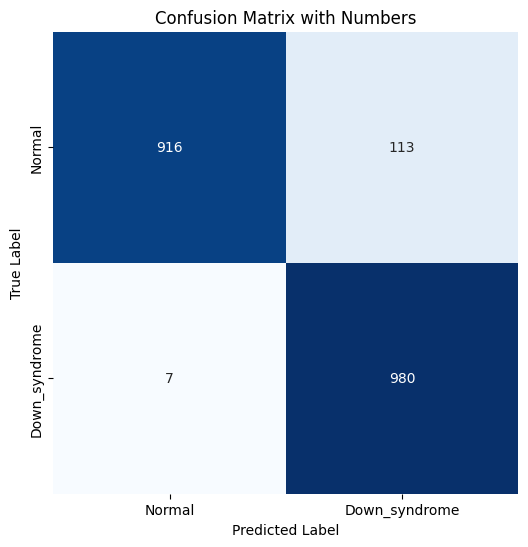

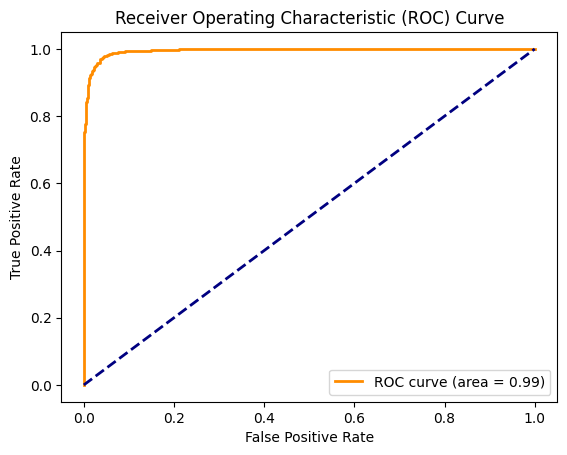

In [11]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Step 1: Load and save the model as a SavedModel
model = load_model('/kaggle/input/customcnn-model/keras/default/1/CustomCnn.keras')
print("Model successfully loaded")

# Export as TensorFlow SavedModel
saved_model_dir = '/kaggle/working/CustomTF_Model'
model.export(saved_model_dir)
print(f"Model successfully exported in SavedModel format at: {saved_model_dir}")

# Step 2: Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
print("Model successfully converted to TFLite format")

# Save the TFLite model
with open('/kaggle/working/CustomTF_Model.tflite', 'wb') as f:
    f.write(tflite_model)
print("CustomTF_Model successfully saved as 'CustomTF_Model.tflite'")

import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="CustomTF_Model.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess and predict on the TensorFlow test dataset
def test_model(test_dataset):
    correct_predictions = 0
    total_predictions = 0
    y_true = []
    y_pred = []
    y_pred_proba = []
    mispredicted_images = []
    start_time = time.time()

    for img_batch, label_batch in test_dataset:
        for i in range(len(img_batch)):
            img = img_batch[i].numpy()
            label = label_batch[i].numpy()

            # Preprocess image to match TFLite model input requirements
            img = np.expand_dims(img, axis=0).astype(np.float32)

            # Set the input tensor
            interpreter.set_tensor(input_details[0]['index'], img)

            # Run the inference
            interpreter.invoke()

            # Get the output tensor
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # Assuming binary classification (output between 0 and 1)
            predicted_class = np.round(output_data[0][0])
            y_pred_proba.append(output_data[0][0])  # Store probability for ROC curve

            # Append true and predicted labels for confusion matrix
            y_true.append(label)
            y_pred.append(predicted_class)

            # Check if prediction is correct
            if predicted_class == label:
                correct_predictions += 1
            else:
                mispredicted_images.append((img.squeeze(), label, predicted_class))  # Store mispredicted images

            total_predictions += 1

    # Calculate accuracy
    accuracy = (correct_predictions / total_predictions) * 100
    inference_time = time.time() - start_time
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Inference Time: {inference_time:.4f} seconds for {total_predictions} images.")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm)

    # Plot ROC Curve
    plot_roc_curve(y_true, y_pred_proba)

    # Display mispredicted images
    #display_mispredicted_images(mispredicted_images)

# Function to plot confusion matrix with numbers
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Normal', 'Down_syndrome'], yticklabels=['Normal', 'Down_syndrome'])
    plt.title('Confusion Matrix with Numbers')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

# Function to display mispredicted images
#def display_mispredicted_images(mispredicted_images):
    #if len(mispredicted_images) == 0:
        #print("No mispredicted images.")
        #return

    #print(f"Displaying {len(mispredicted_images)} mispredicted images:")
    #for img, true_label, pred_label in mispredicted_images:
        #plt.imshow(img)
        #plt.title(f"True: {'Normal' if true_label == 0 else 'Down_syndrome'} | Pred: {'Normal' if pred_label == 0 else 'Down_syndrome'}")
        #plt.axis('off')
        #lt.show()


# Run the test on the test dataset
test_model(test)


Model successfully loaded
Saved artifact at '/kaggle/working/CustomQTF_Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140177400730672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177533593984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177400311904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177400312256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177400626720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177400618448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177400833552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177400827568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177398900416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177398899008: TensorSpec(shape=(), dtype=

W0000 00:00:1731196523.705328      30 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1731196523.705357      30 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


Model successfully converted to TFLite format
CustomQTF_Model successfully saved as 'CustomQTF_Model.tflite'
Accuracy: 94.25%
Inference Time: 49.9567 seconds for 2016 images.


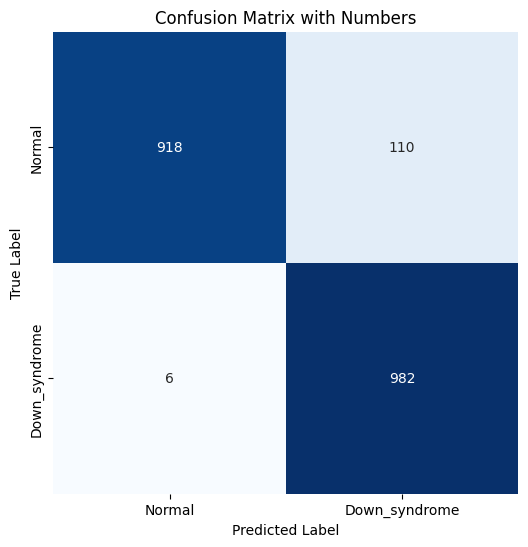

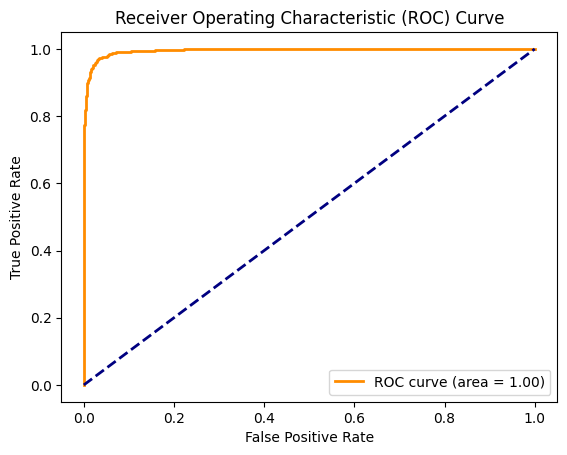

In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Step 1: Load and save the model as a SavedModel
model = load_model('/kaggle/input/customcnn-model/keras/default/1/CustomCnn.keras')
print("Model successfully loaded")

# Export as TensorFlow SavedModel
saved_model_dir = '/kaggle/working/CustomQTF_Model'
model.export(saved_model_dir)
print(f"Model successfully exported in SavedModel format at: {saved_model_dir}")

# Step 2: Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
print("Model successfully converted to TFLite format")

# Save the TFLite model
with open('/kaggle/working/CustomQTF_Model.tflite', 'wb') as f:
    f.write(tflite_quant_model)
print("CustomQTF_Model successfully saved as 'CustomQTF_Model.tflite'")

import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="CustomQTF_Model.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess and predict on the TensorFlow test dataset
def test_model(test_dataset):
    correct_predictions = 0
    total_predictions = 0
    y_true = []
    y_pred = []
    y_pred_proba = []
    mispredicted_images = []
    start_time = time.time()

    for img_batch, label_batch in test_dataset:
        for i in range(len(img_batch)):
            img = img_batch[i].numpy()
            label = label_batch[i].numpy()

            # Preprocess image to match TFLite model input requirements
            img = np.expand_dims(img, axis=0).astype(np.float32)

            # Set the input tensor
            interpreter.set_tensor(input_details[0]['index'], img)

            # Run the inference
            interpreter.invoke()

            # Get the output tensor
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # Assuming binary classification (output between 0 and 1)
            predicted_class = np.round(output_data[0][0])
            y_pred_proba.append(output_data[0][0])  # Store probability for ROC curve

            # Append true and predicted labels for confusion matrix
            y_true.append(label)
            y_pred.append(predicted_class)

            # Check if prediction is correct
            if predicted_class == label:
                correct_predictions += 1
            else:
                mispredicted_images.append((img.squeeze(), label, predicted_class))  # Store mispredicted images

            total_predictions += 1

    # Calculate accuracy
    accuracy = (correct_predictions / total_predictions) * 100
    inference_time = time.time() - start_time
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Inference Time: {inference_time:.4f} seconds for {total_predictions} images.")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm)

    # Plot ROC Curve
    plot_roc_curve(y_true, y_pred_proba)

    # Display mispredicted images
    #display_mispredicted_images(mispredicted_images)

# Function to plot confusion matrix with numbers
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Normal', 'Down_syndrome'], yticklabels=['Normal', 'Down_syndrome'])
    plt.title('Confusion Matrix with Numbers')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

# Function to display mispredicted images
#def display_mispredicted_images(mispredicted_images):
    #if len(mispredicted_images) == 0:
        #print("No mispredicted images.")
        #return

    #print(f"Displaying {len(mispredicted_images)} mispredicted images:")
    #for img, true_label, pred_label in mispredicted_images:
        #plt.imshow(img)
        #plt.title(f"True: {'Normal' if true_label == 0 else 'Down_syndrome'} | Pred: {'Normal' if pred_label == 0 else 'Down_syndrome'}")
        #plt.axis('off')
        #lt.show()


# Run the test on the test dataset
test_model(test)


Model successfully loaded
Saved artifact at '/kaggle/working/CustomFlot16QTF_Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140177533643488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177533593104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940821296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940822352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940097584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177939798800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940809504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940807744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940622576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940626976: TensorSpec(shape=(), 

W0000 00:00:1731196576.069764      30 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1731196576.069791      30 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


Model successfully converted to TFLite format
CustomFlot16QTF_Model successfully saved as 'CustomFlot16QTF_Model.tflite'
Accuracy: 94.54%
Inference Time: 53.0097 seconds for 2016 images.


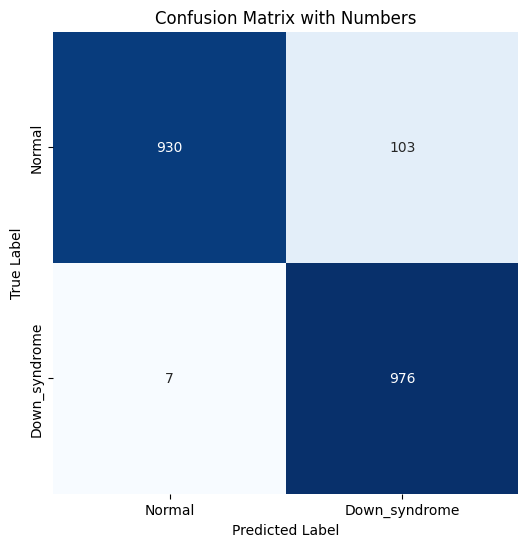

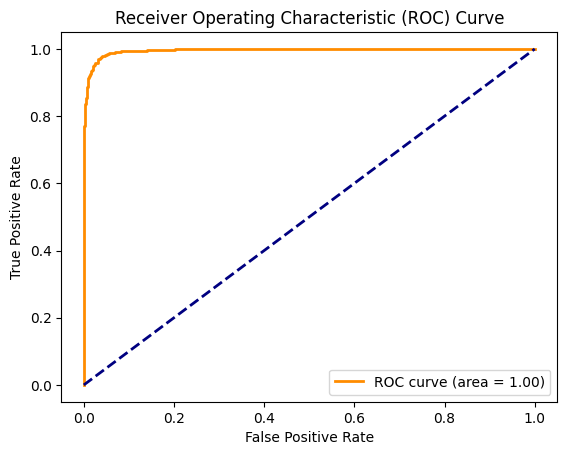

In [13]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Step 1: Load and save the model as a SavedModel
model = load_model('/kaggle/input/customcnn-model/keras/default/1/CustomCnn.keras')
print("Model successfully loaded")

# Export as TensorFlow SavedModel
saved_model_dir = '/kaggle/working/CustomFlot16QTF_Model'
model.export(saved_model_dir)
print(f"Model successfully exported in SavedModel format at: {saved_model_dir}")

# Step 2: Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_float16_quant_model = converter.convert()
print("Model successfully converted to TFLite format")

# Save the TFLite model
with open('/kaggle/working/CustomFlot16QTF_Model.tflite', 'wb') as f:
    f.write(tflite_float16_quant_model)
print("CustomFlot16QTF_Model successfully saved as 'CustomFlot16QTF_Model.tflite'")

import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="CustomFlot16QTF_Model.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess and predict on the TensorFlow test dataset
def test_model(test_dataset):
    correct_predictions = 0
    total_predictions = 0
    y_true = []
    y_pred = []
    y_pred_proba = []
    mispredicted_images = []
    start_time = time.time()

    for img_batch, label_batch in test_dataset:
        for i in range(len(img_batch)):
            img = img_batch[i].numpy()
            label = label_batch[i].numpy()

            # Preprocess image to match TFLite model input requirements
            img = np.expand_dims(img, axis=0).astype(np.float32)

            # Set the input tensor
            interpreter.set_tensor(input_details[0]['index'], img)

            # Run the inference
            interpreter.invoke()

            # Get the output tensor
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # Assuming binary classification (output between 0 and 1)
            predicted_class = np.round(output_data[0][0])
            y_pred_proba.append(output_data[0][0])  # Store probability for ROC curve

            # Append true and predicted labels for confusion matrix
            y_true.append(label)
            y_pred.append(predicted_class)

            # Check if prediction is correct
            if predicted_class == label:
                correct_predictions += 1
            else:
                mispredicted_images.append((img.squeeze(), label, predicted_class))  # Store mispredicted images

            total_predictions += 1

    # Calculate accuracy
    accuracy = (correct_predictions / total_predictions) * 100
    inference_time = time.time() - start_time
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Inference Time: {inference_time:.4f} seconds for {total_predictions} images.")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm)

    # Plot ROC Curve
    plot_roc_curve(y_true, y_pred_proba)

    # Display mispredicted images
    #display_mispredicted_images(mispredicted_images)

# Function to plot confusion matrix with numbers
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Normal', 'Down_syndrome'], yticklabels=['Normal', 'Down_syndrome'])
    plt.title('Confusion Matrix with Numbers')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

# Function to display mispredicted images
#def display_mispredicted_images(mispredicted_images):
    #if len(mispredicted_images) == 0:
        #print("No mispredicted images.")
        #return

    #print(f"Displaying {len(mispredicted_images)} mispredicted images:")
    #for img, true_label, pred_label in mispredicted_images:
        #plt.imshow(img)
        #plt.title(f"True: {'Normal' if true_label == 0 else 'Down_syndrome'} | Pred: {'Normal' if pred_label == 0 else 'Down_syndrome'}")
        #plt.axis('off')
        #lt.show()


# Run the test on the test dataset
test_model(test)


Model successfully loaded
Saved artifact at '/kaggle/working/Custom16_8QTF_Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140177101344960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177940794704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177397898528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177397899936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177538815376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177397901344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177101304784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177101303024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177101810400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140177101811456: TensorSpec(shape=(), dt

W0000 00:00:1731196631.320553      30 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1731196631.320581      30 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


Model successfully converted to TFLite format
Custom16_8QTF_Model successfully saved as 'Custom16_8QTF_Model.tflite'
Accuracy: 94.25%
Inference Time: 48.6507 seconds for 2016 images.


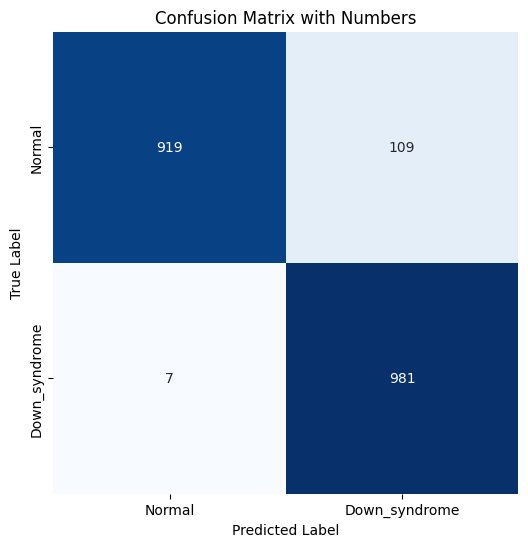

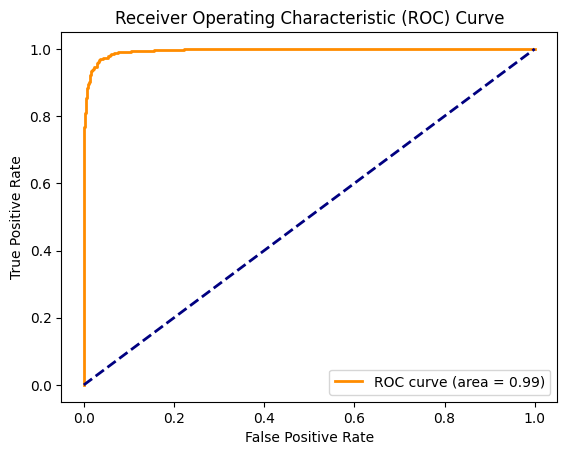

In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Step 1: Load and save the model as a SavedModel
model = load_model('/kaggle/input/customcnn-model/keras/default/1/CustomCnn.keras')
print("Model successfully loaded")

# Export as TensorFlow SavedModel
saved_model_dir = '/kaggle/working/Custom16_8QTF_Model'
model.export(saved_model_dir)
print(f"Model successfully exported in SavedModel format at: {saved_model_dir}")

# Step 2: Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
tflite_16x8_quant_model = converter.convert()
print("Model successfully converted to TFLite format")

# Save the TFLite model
with open('/kaggle/working/Custom16_8QTF_Model.tflite', 'wb') as f:
    f.write(tflite_16x8_quant_model)
print("Custom16_8QTF_Model successfully saved as 'Custom16_8QTF_Model.tflite'")

import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="Custom16_8QTF_Model.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess and predict on the TensorFlow test dataset
def test_model(test_dataset):
    correct_predictions = 0
    total_predictions = 0
    y_true = []
    y_pred = []
    y_pred_proba = []
    mispredicted_images = []
    start_time = time.time()

    for img_batch, label_batch in test_dataset:
        for i in range(len(img_batch)):
            img = img_batch[i].numpy()
            label = label_batch[i].numpy()

            # Preprocess image to match TFLite model input requirements
            img = np.expand_dims(img, axis=0).astype(np.float32)

            # Set the input tensor
            interpreter.set_tensor(input_details[0]['index'], img)

            # Run the inference
            interpreter.invoke()

            # Get the output tensor
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # Assuming binary classification (output between 0 and 1)
            predicted_class = np.round(output_data[0][0])
            y_pred_proba.append(output_data[0][0])  # Store probability for ROC curve

            # Append true and predicted labels for confusion matrix
            y_true.append(label)
            y_pred.append(predicted_class)

            # Check if prediction is correct
            if predicted_class == label:
                correct_predictions += 1
            else:
                mispredicted_images.append((img.squeeze(), label, predicted_class))  # Store mispredicted images

            total_predictions += 1

    # Calculate accuracy
    accuracy = (correct_predictions / total_predictions) * 100
    inference_time = time.time() - start_time
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Inference Time: {inference_time:.4f} seconds for {total_predictions} images.")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm)

    # Plot ROC Curve
    plot_roc_curve(y_true, y_pred_proba)

    # Display mispredicted images
    #display_mispredicted_images(mispredicted_images)

# Function to plot confusion matrix with numbers
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Normal', 'Down_syndrome'], yticklabels=['Normal', 'Down_syndrome'])
    plt.title('Confusion Matrix with Numbers')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

# Function to display mispredicted images
#def display_mispredicted_images(mispredicted_images):
    #if len(mispredicted_images) == 0:
        #print("No mispredicted images.")
        #return

    #print(f"Displaying {len(mispredicted_images)} mispredicted images:")
    #for img, true_label, pred_label in mispredicted_images:
        #plt.imshow(img)
        #plt.title(f"True: {'Normal' if true_label == 0 else 'Down_syndrome'} | Pred: {'Normal' if pred_label == 0 else 'Down_syndrome'}")
        #plt.axis('off')
        #lt.show()


# Run the test on the test dataset
test_model(test)
